# Force analysis of ActuAtor

In [88]:
%matplotlib inline
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import automembrane.util as u
from automembrane.energy import getEnergy2DClosed, getEnergy2DClosed_notrace, getEnergy2DOpen

from pathlib import Path

from tqdm.notebook import tqdm

files = list(
    map(
        Path,
        [
            f"coordinates/{i}"
            for i in [
                "cell1/34D-grid2-s3-acta1_001_16.txt",
                "cell2/34D-grid3-ActA1_007_16.txt",
                "cell2/34D-grid3-ActA1_013_16.txt",
                "cell3/34D-grid2-s2_002_16.txt",
                "cell3/34D-grid2-s5_005_16.txt",
                "cell3/34D-grid3-ActA1_020_16.txt",
                "cell3/34D-grid3-s6_005_16.txt",
                "cell4/34D-grid2-s3_028_16.txt",
                "cell5/34D-grid3-ActA1_001_16.txt",
                "cell5/34D-grid3-ActA1_002_16.txt",
                "cell5/34D-grid3-ActA1_003_16.txt",
                "cell5/34D-grid3-ActA1_004_16.txt",
            ]
        ],
    )
)


parameters = {
    "Kb": 0.1,  # Bending modulus (pN um; original 1e-19 J) 
    "Kbc": 0,  # Constant of bending modulus vs protein density
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "At": 0,  # Preferred area
    "epsilon": 0,  # Binding energy per protein
    "Kv": 0,  # pressure-volume modulus
    "Vt": 0,  # Volume target
}

import matplotlib as mpl

u.matplotlibStyle(small=10, medium=12, large=14)

f_energy = partial(getEnergy2DClosed, **parameters)


Processing: coordinates/cell1/34D-grid2-s3-acta1_001_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2903.51171875 2901.24511719 2899.17553711 2897.26611328 2895.48950195
 2893.82519531 2892.25683594 2890.77172852 2889.36132812 2888.01733398
 2886.73388672 2885.50463867 2884.32543945 2883.19140625 2882.10009766
 2881.04858398 2880.03320312 2879.05126953 2878.10131836 2877.18139648
 2876.2902832  2875.42407227 2874.58398438 2873.76708984 2872.97290039
 2872.20043945 2871.44775391 2870.71362305 2869.99707031 2869.29785156
 2868.61499023 2867.94824219 2867.29638672 2866.66015625 2866.03735352
 2865.42773438 2864.83032227 2864.24438477 2863.6706543  2863.10742188
 2862.55639648 2862.01611328 2861.484375   2860.96240234 2860.45019531
 2859.94726562 2859.45239258 2858.96606445 2858.48754883 2858.01708984
 2857.55322266 2857.09643555 2856.64794922 2856.20532227 2855.76977539
 2855.34106445 2854.91723633 2854.49951172 2854.08789062 2853.68261719
 2853.28222656 2852.88745117 2852.49829102 2852.11425781 2851.73510742
 2851.36083984 2850.99072266 2850.62548828 2850.2644043  2849.90722656
 2849.

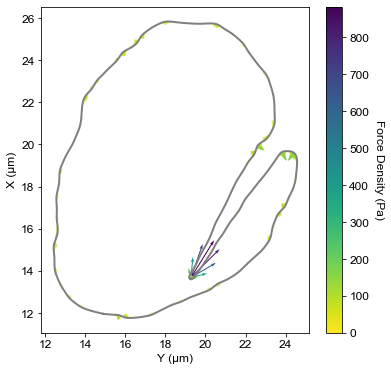

Processing: coordinates/cell2/34D-grid3-ActA1_007_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2199.68896484 2198.28344727 2197.02075195 2195.86328125 2194.78735352
 2193.77832031 2192.82568359 2191.921875   2191.06079102 2190.23803711
 2189.45019531 2188.69360352 2187.96606445 2187.26464844 2186.58837891
 2185.93554688 2185.30297852 2184.69042969 2184.09716797 2183.52075195
 2182.9609375  2182.41650391 2181.88574219 2181.36914062 2180.86572266
 2180.37451172 2179.89477539 2179.42626953 2178.96801758 2178.51953125
 2178.08032227 2177.65039062 2177.22998047 2176.81713867 2176.4128418
 2176.015625   2175.62524414 2175.24267578 2174.86645508 2174.49682617
 2174.13354492 2173.77587891 2173.42407227 2173.07763672 2172.73706055
 2172.40185547 2172.07128906 2171.74584961 2171.42504883 2171.10839844
 2170.79614258 2170.48876953 2170.18603516 2169.88696289 2169.59204102
 2169.30029297 2169.01196289 2168.72753906 2168.44677734 2168.16992188
 2167.89624023 2167.62548828 2167.35766602 2167.09301758 2166.83154297
 2166.57299805 2166.31713867 2166.06420898 2165.81420898 2165.56616211
 2165.3

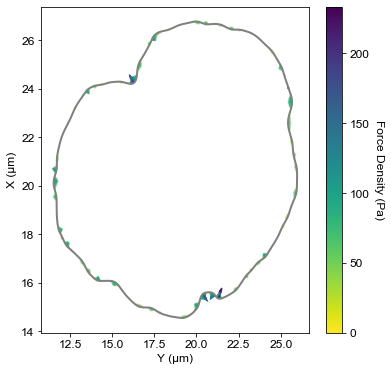

Processing: coordinates/cell2/34D-grid3-ActA1_013_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2144.75512695 2142.39306641 2140.5925293  2139.02490234 2137.58691406
 2136.23828125 2134.96020508 2133.74072266 2132.5715332  2131.44775391
 2130.36328125 2129.31518555 2128.30126953 2127.31762695 2126.36303711
 2125.43579102 2124.53369141 2123.65527344 2122.79833984 2121.96386719
 2121.1496582  2120.35498047 2119.57788086 2118.81835938 2118.07543945
 2117.34985352 2116.6394043  2115.94311523 2115.26196289 2114.59399414
 2113.93896484 2113.29638672 2112.66552734 2112.046875   2111.43920898
 2110.84179688 2110.25610352 2109.67993164 2109.11401367 2108.55761719
 2108.01025391 2107.47216797 2106.94262695 2106.42089844 2105.9074707
 2105.40161133 2104.90332031 2104.41235352 2103.9296875  2103.45410156
 2102.98486328 2102.52148438 2102.06494141 2101.61450195 2101.16992188
 2100.73144531 2100.29956055 2099.87304688 2099.4519043  2099.03588867
 2098.62573242 2098.22045898 2097.81958008 2097.42382812 2097.03173828
 2096.64501953 2096.26269531 2095.88452148 2095.51074219 2095.14111328
 2094.7

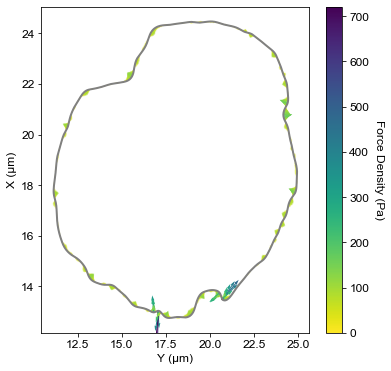

Processing: coordinates/cell3/34D-grid2-s2_002_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2653.00219727 2645.42138672 2639.62207031 2634.58813477 2630.04858398
 2625.87646484 2621.99658203 2618.35791016 2614.92529297 2611.66992188
 2608.57470703 2605.61889648 2602.79296875 2600.08398438 2597.47998047
 2594.97460938 2592.55932617 2590.22827148 2587.97485352 2585.79272461
 2583.67797852 2581.62597656 2579.63330078 2577.69628906 2575.81054688
 2573.97485352 2572.18530273 2570.44018555 2568.73657227 2567.07373047
 2565.44775391 2563.85791016 2562.30249023 2560.78076172 2559.29125977
 2557.83203125 2556.40185547 2554.9987793  2553.62329102 2552.27246094
 2550.94750977 2549.64599609 2548.36791992 2547.11279297 2545.87939453
 2544.66650391 2543.47412109 2542.30102539 2541.14672852 2540.01147461
 2538.89282227 2537.79248047 2536.71020508 2535.64282227 2534.59155273
 2533.55615234 2532.53613281 2531.52880859 2530.53637695 2529.55810547
 2528.59277344 2527.64111328 2526.70141602 2525.77392578 2524.85961914
 2523.95776367 2523.06640625 2522.1862793  2521.31811523 2520.46020508
 2519.

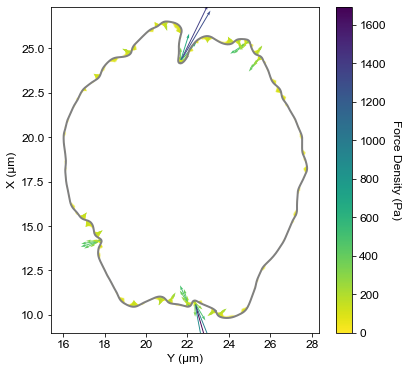

Processing: coordinates/cell3/34D-grid2-s5_005_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2846.2409668  2834.07788086 2828.24682617 2823.24047852 2818.73486328
 2814.58740234 2810.71557617 2807.06420898 2803.59521484 2800.28149414
 2797.09936523 2794.03344727 2791.0703125  2788.19921875 2785.41162109
 2782.70019531 2780.06005859 2777.48461914 2774.96850586 2772.5090332
 2770.10351562 2767.74853516 2765.43994141 2763.17773438 2760.95874023
 2758.77929688 2756.64038086 2754.53759766 2752.47045898 2750.43823242
 2748.43994141 2746.47387695 2744.53759766 2742.63085938 2740.75390625
 2738.90332031 2737.08007812 2735.28271484 2733.51171875 2731.76513672
 2730.04174805 2728.34277344 2726.66455078 2725.00854492 2723.37426758
 2721.76098633 2720.16748047 2718.59375    2717.04052734 2715.50512695
 2713.98901367 2712.49047852 2711.01000977 2709.546875   2708.10009766
 2706.66967773 2705.25537109 2703.8581543  2702.47583008 2701.10913086
 2699.76098633 2698.67211914 2697.10668945 2695.7980957  2694.50292969
 2693.22143555 2691.953125   2690.69726562 2689.45556641 2688.22680664
 2687.1

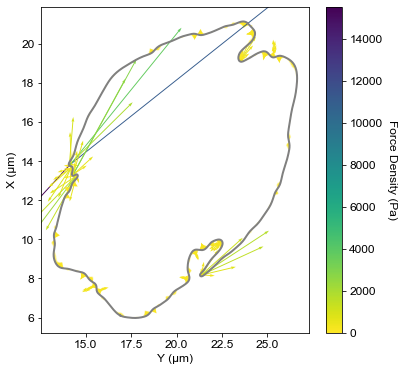

Processing: coordinates/cell3/34D-grid3-ActA1_020_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2654.57714844 2651.50415039 2648.83935547 2646.41577148 2644.15820312
 2642.02636719 2639.99560547 2638.04833984 2636.17504883 2634.36645508
 2632.61816406 2630.92407227 2629.27929688 2627.68237305 2626.12866211
 2624.61621094 2623.14160156 2621.70385742 2620.30078125 2618.93139648
 2617.5925293  2616.28393555 2615.00390625 2613.75048828 2612.52270508
 2611.32080078 2610.1418457  2608.98608398 2607.85131836 2606.73657227
 2605.64306641 2604.56933594 2603.5144043  2602.47729492 2601.45776367
 2600.45410156 2599.46704102 2598.49560547 2597.53979492 2596.59887695
 2595.67285156 2594.75952148 2593.86083984 2592.97509766 2592.1015625
 2591.24072266 2590.39208984 2589.5546875  2588.72949219 2587.91430664
 2587.10986328 2586.31542969 2585.53100586 2584.7565918  2583.99169922
 2583.23657227 2582.4909668  2581.75390625 2581.02539062 2580.30541992
 2579.59423828 2578.8918457  2578.19750977 2577.50976562 2576.83032227
 2576.1574707  2575.4921875  2574.8347168  2574.18457031 2573.54174805
 2572.9

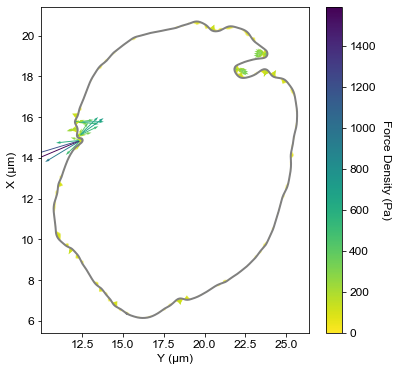

Processing: coordinates/cell3/34D-grid3-s6_005_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2318.88232422 2316.07348633 2313.66210938 2311.50878906 2309.5402832
 2307.71289062 2306.00219727 2304.38793945 2302.85791016 2301.40136719
 2300.01000977 2298.67749023 2297.3984375  2296.16723633 2294.98046875
 2293.83374023 2292.72485352 2291.65063477 2290.6081543  2289.59619141
 2288.61206055 2287.65454102 2286.72143555 2285.81201172 2284.92480469
 2284.05859375 2283.21313477 2282.38671875 2281.57763672 2280.78588867
 2280.01147461 2279.25244141 2278.50878906 2277.77954102 2277.06396484
 2276.36206055 2275.67236328 2274.99633789 2274.33178711 2273.67871094
 2273.03613281 2272.40454102 2271.78369141 2271.17163086 2270.57006836
 2269.97827148 2269.39501953 2268.8203125  2268.25439453 2267.69726562
 2267.1484375  2266.60693359 2266.07373047 2265.54785156 2265.02856445
 2264.51635742 2264.01049805 2263.51123047 2263.01904297 2262.53320312
 2262.05322266 2261.5793457  2261.11132812 2260.64916992 2260.19165039
 2259.73999023 2259.29345703 2258.85253906 2258.41699219 2257.98608398
 2257.5

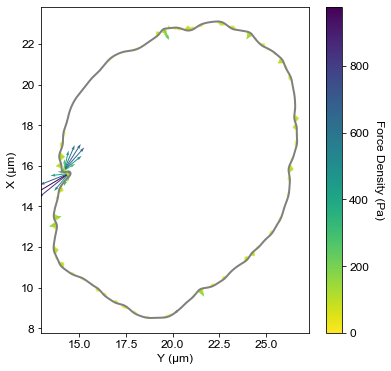

Processing: coordinates/cell4/34D-grid2-s3_028_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2124.99682617 2122.06518555 2119.62402344 2117.49926758 2115.59375
 2113.85253906 2112.2421875  2110.73852539 2109.32641602 2107.9934082
 2106.72998047 2105.52856445 2104.38183594 2103.28466797 2102.23242188
 2101.22143555 2100.24780273 2099.30834961 2098.40039062 2097.52124023
 2096.66918945 2095.84204102 2095.03857422 2094.2578125  2093.49707031
 2092.75634766 2092.03295898 2091.32788086 2090.63867188 2089.96508789
 2089.30688477 2088.66308594 2088.0324707  2087.41503906 2086.80908203
 2086.21582031 2085.63330078 2085.0612793  2084.50073242 2083.94970703
 2083.40844727 2082.87597656 2082.35302734 2081.83886719 2081.33276367
 2080.83398438 2080.34399414 2079.86132812 2079.38623047 2078.91870117
 2078.45776367 2078.00341797 2077.55517578 2077.11328125 2076.67700195
 2076.24755859 2075.82299805 2075.40454102 2074.99243164 2074.58618164
 2074.18457031 2073.78759766 2073.39526367 2073.00854492 2072.62597656
 2072.24829102 2071.875      2071.50610352 2071.14111328 2070.78051758
 2070.4245

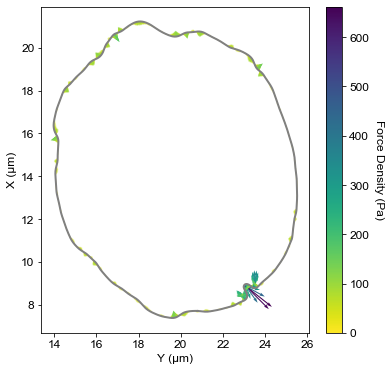

Processing: coordinates/cell5/34D-grid3-ActA1_001_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2102.73242188 2099.68554688 2097.40869141 2095.40405273 2093.57568359
 2091.88500977 2090.30493164 2088.81982422 2087.41601562 2086.08447266
 2084.81689453 2083.60595703 2082.44750977 2081.33569336 2080.26708984
 2079.23779297 2078.24536133 2077.2878418  2076.36132812 2075.46508789
 2074.59667969 2073.75366211 2072.93457031 2072.13964844 2071.36523438
 2070.61157227 2069.87768555 2069.16186523 2068.46411133 2067.7824707
 2067.1171875  2066.46728516 2065.83129883 2065.2097168  2064.60131836
 2064.00512695 2063.42089844 2062.84912109 2062.28833008 2061.73852539
 2061.19946289 2060.67041016 2060.15112305 2059.64135742 2059.14038086
 2058.6484375  2058.1652832  2057.69018555 2057.22314453 2056.76391602
 2056.3125     2055.86791992 2055.43017578 2054.99951172 2054.57543945
 2054.15722656 2053.74536133 2053.33935547 2052.93920898 2052.54541016
 2052.15673828 2051.77416992 2051.3972168  2051.02514648 2050.65869141
 2050.296875   2049.94018555 2049.58813477 2049.24072266 2048.89794922
 2048.5

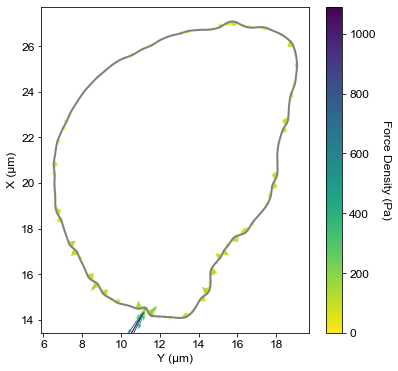

Processing: coordinates/cell5/34D-grid3-ActA1_002_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[1949.75463867 1945.52685547 1942.16809082 1939.31506348 1936.80493164
 1934.54748535 1932.48718262 1930.58935547 1928.82495117 1927.17504883
 1925.625      1924.16333008 1922.77868652 1921.46496582 1920.21435547
 1919.02124023 1917.88024902 1916.78808594 1915.74023438 1914.73291016
 1913.76379395 1912.83129883 1911.93225098 1911.06347656 1910.22375488
 1909.41296387 1908.6282959  1907.86804199 1907.13134766 1906.41589355
 1905.72155762 1905.04711914 1904.39147949 1903.7545166  1903.13513184
 1902.53186035 1901.94470215 1901.37329102 1900.81469727 1900.27099609
 1899.74084473 1899.22424316 1898.71948242 1898.22570801 1897.74377441
 1897.27233887 1896.81213379 1896.3626709  1895.92285156 1895.49255371
 1895.07055664 1894.65783691 1894.25439453 1893.85925293 1893.47155762
 1893.09265137 1892.7208252  1892.35571289 1891.99768066 1891.64685059
 1891.30310059 1890.96569824 1890.6340332  1890.30871582 1889.98950195
 1889.67590332 1889.36828613 1889.06616211 1888.76879883 1888.47680664
 1888.

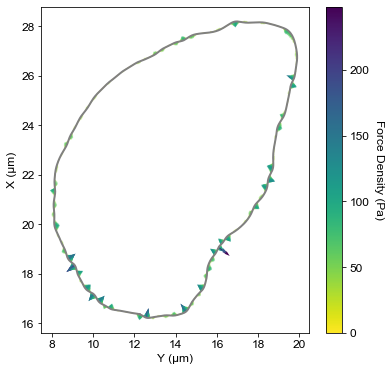

Processing: coordinates/cell5/34D-grid3-ActA1_003_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2123.83691406 2121.40283203 2119.2878418  2117.39428711 2115.66894531
 2114.07763672 2112.59667969 2111.21044922 2109.90551758 2108.67285156
 2107.50488281 2106.39331055 2105.33349609 2104.32104492 2103.35131836
 2102.42089844 2101.52685547 2100.66577148 2099.8359375  2099.03540039
 2098.26196289 2097.51391602 2096.7890625  2096.0859375  2095.40429688
 2094.74267578 2094.09960938 2093.47412109 2092.86523438 2092.27294922
 2091.69580078 2091.1328125  2090.58374023 2090.04736328 2089.52441406
 2089.01342773 2088.51367188 2088.02490234 2087.54638672 2087.07885742
 2086.62158203 2086.17382812 2085.734375   2085.3046875  2084.88305664
 2084.46899414 2084.0637207  2083.66625977 2083.27661133 2082.89428711
 2082.51879883 2082.15039062 2081.78808594 2081.43237305 2081.08325195
 2080.73974609 2080.40136719 2080.06884766 2079.74243164 2079.42114258
 2079.10546875 2078.79467773 2078.48828125 2078.18725586 2077.89086914
 2077.59912109 2077.31201172 2077.02929688 2076.75073242 2076.4765625
 2076.2

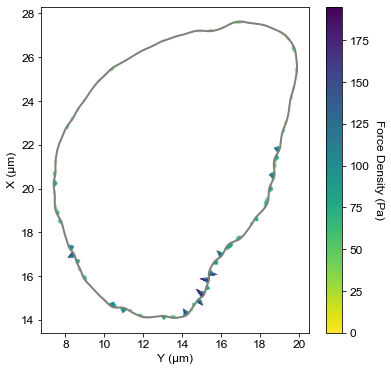

Processing: coordinates/cell5/34D-grid3-ActA1_004_16.txt


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

[2096.01806641 2094.80639648 2093.70239258 2092.67211914 2091.69824219
 2090.77026367 2089.88037109 2089.0234375  2088.1965332  2087.39624023
 2086.62036133 2085.86743164 2085.13354492 2084.41918945 2083.72290039
 2083.04370117 2082.38037109 2081.73168945 2081.09790039 2080.47680664
 2079.86889648 2079.27319336 2078.68847656 2078.11572266 2077.55371094
 2077.00244141 2076.4609375  2075.92944336 2075.40771484 2074.89453125
 2074.38989258 2073.89379883 2073.40576172 2072.92529297 2072.45288086
 2071.98779297 2071.52929688 2071.07910156 2070.63476562 2070.19702148
 2069.76586914 2069.34082031 2068.92236328 2068.51025391 2068.10400391
 2067.703125   2067.30761719 2066.91723633 2066.53295898 2066.15307617
 2065.77880859 2065.41015625 2065.04541016 2064.68579102 2064.33056641
 2063.97973633 2063.6328125  2063.29077148 2062.95288086 2062.61938477
 2062.28955078 2061.96337891 2061.64111328 2061.32299805 2061.00854492
 2060.69799805 2060.39038086 2060.08691406 2059.78662109 2059.49023438
 2059.

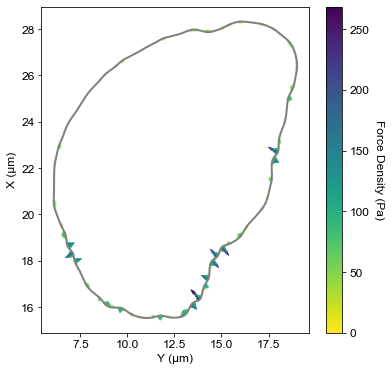

In [90]:
from scipy.interpolate import splprep, splev

n_vertices = 1000  # Number of vertices in resampling
dt = 5e-6  # Timestep
n_iter = 1000  # Number of relaxation steps
energy_log = np.zeros(n_iter)

cm = mpl.cm.viridis_r

for file in files:
    print("Processing:", file)
    original_coords = np.loadtxt(file)
    original_coords = np.vstack(
        (original_coords, original_coords[0])
    )  # Energy expects last point to equal first

    # Periodic cubic B-spline interpolation with no smoothing (s=0)
    tck, _ = splprep([original_coords[:, 0], original_coords[:, 1]], s=0, per=True)
    xi, yi = splev(np.linspace(0, 1, n_vertices), tck)
    coords = np.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))

    relaxed_coords = coords
    for i in tqdm(range(0, n_iter), desc="Energy relaxation"):
        energy_log[i] = f_energy(relaxed_coords)
        relaxed_coords = np.array(
            relaxed_coords - u.egrad(f_energy)(relaxed_coords) * dt
        )
        relaxed_coords[-1] = relaxed_coords[0]
    print(energy_log[::10])

    print(getEnergy2DClosed_notrace(relaxed_coords, **parameters))

    x = relaxed_coords[:-1, 0]
    y = relaxed_coords[:-1, 1]

    dx = np.roll(x, -1) - x
    dy = np.roll(y, -1) - y
    edgeLengths = np.sqrt(dx**2 + dy**2)
    dualLengths = ((edgeLengths + np.roll(edgeLengths, 1)) / 2.0).reshape(-1, 1)
    dualLengths = np.vstack((dualLengths, dualLengths[0]))

    forces = -u.egrad(f_energy)(relaxed_coords) / dualLengths
    f_mag = np.linalg.norm(forces, axis=1)

 
    norm = mpl.colors.Normalize(vmin=np.amin(f_mag), vmax=np.amax(f_mag))
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
    ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray")

    ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        forces[:, 0],
        forces[:, 1],
        units = 'xy',
        label="force",
        color=colors,
        scale = 400,
        width= 0.05
    )
    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = cm), ax = ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel("Force Density (Pa)", rotation=270)

    plt.show()


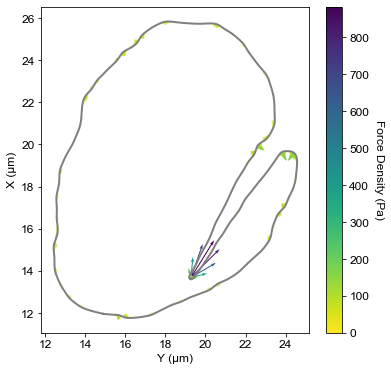

In [86]:

cm = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=np.amin(f_mag), vmax=np.amax(f_mag))
# Map values to colors and add vertex color layer
colors = cm(norm(f_mag))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray")

ax.quiver(
    relaxed_coords[:, 0],
    relaxed_coords[:, 1],
    forces[:, 0],
    forces[:, 1],
    units = 'xy',
    label="force",
    color=colors,
    scale = 400,
    width= 0.05
)
ax.set_ylabel(r"X (μm)")
ax.set_xlabel(r"Y (μm)")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = cm), ax = ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Force Density (Pa)", rotation=270)

plt.show()

## Without interpolation

Processing: coordinates/cell1/34D-grid2-s3-acta1_001_16.txt


Energy relaxation:   0%|          | 0/100 [00:00<?, ?it/s]

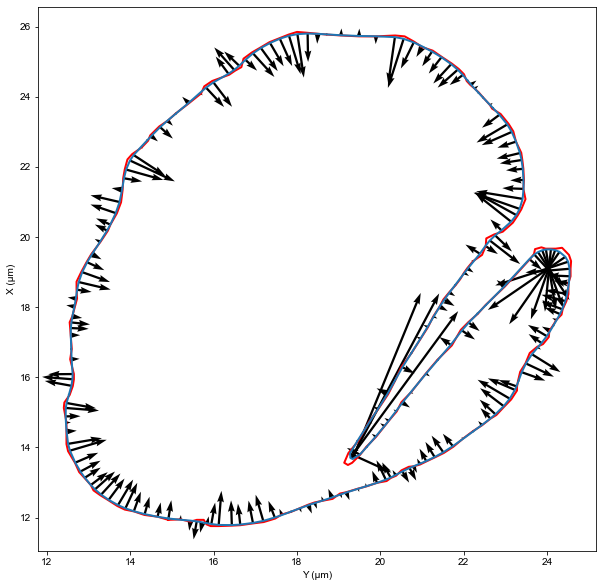

In [21]:
dt = 5e13

for file in files[0:1]:
    print("Processing:", file)
    coords = np.loadtxt(file)
    coords = np.vstack((coords, coords[0]))  # Energy expects last point to equal first
    energy = f_energy(coords)
    relaxed_coords = coords
    
    for i in tqdm(range(0, 100), desc="Energy relaxation"):
        energy = f_energy(relaxed_coords)
        relaxed_coords = np.array(relaxed_coords - u.egrad(f_energy)(relaxed_coords) * dt)
        relaxed_coords[-1] = relaxed_coords[0]
    forces = - u.egrad(f_energy)(relaxed_coords)
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.plot(coords[:,0], coords[:,1], color='r') 
    ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1])

    ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        forces[:, 0],
        forces[:, 1],
        label="force",
    )
    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")
    plt.show()


49 nm^2 -> 4.9e-5 um^2
1/4.9e-5 -> 20408

1/4.9e-5  * 0.05 -> 1020

conclude about 5% area coverage of pushing actin



